### Import Block

In [108]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cudf
import cuspatial
import geopy.distance as gpx
import itertools

### Function Definitions

In [ ]:
# Source: https://medium.com/swlh/how-to-perform-fast-and-powerful-geospatial-data-analysis-with-gpu-48f16a168b10
def create_iterations(start, end, batches):
    iterations = list(np.arange(start, end, batches))
    iterations.append(end)
    return iterations

def perform_pip(cuda_df, cuspatial_data, iter_batch):
    cuda_df['polygonID'] = " "
    for i in range(len(iter_batch)-1):
        start = pip_iterations[i]
        end = pip_iterations[i+1]
        pip = cuspatial.point_in_polygon(cuda_df['Lon'] , cuda_df['Lat'], 
                                         cuspatial_data[0][start:end], 
                                         cuspatial_data[1], 
                                         cuspatial_data[2]['x'], 
                                         cuspatial_data[2]['y']
                                        )

        for i in pip.columns:
            cuda_df['polygonID'].loc[pip[i]] = i
    return cuda_df

In [ ]:
def any_pip(cuda_df, cuspatial_data, iter_batch):
    cuda_df['pip_count'] = 0
    for i in range(len(iter_batch)-1):
        start = pip_iterations[i]
        end = pip_iterations[i+1]
        pip = cuspatial.point_in_polygon(cuda_df['Lon'] , cuda_df['Lat'], 
                                         cuspatial_data[0][start:end], 
                                         cuspatial_data[1], 
                                         cuspatial_data[2]['x'], 
                                         cuspatial_data[2]['y']
                                        )
        
        # Count number of polygons that each point touches.
        for col in pip.columns:
            cuda_df['pip_count'] += col
    
    # If point touches any polygons, maek any_pip as True.
    cuda_df['any_pip'] = cuda_df['pip_count'] > 0
    return cuda_df

### Get Data

In [12]:
%%time
# Load shapefile.
deforestation = cuspatial.read_polygon_shapefile('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

CPU times: user 5.8 s, sys: 2.27 s, total: 8.07 s
Wall time: 21.4 s


In [ ]:
%%time
# Load VIIRS data back into memory from CSV.
px_combined = cudf.read_csv('VIIRS_Para.csv')

### Testing Polygon Subtraction

In [3]:
deforestation = gpd.read_file('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')
state_shapes = gpd.read_file('States_Amazon_Biome/states_amazon_biome.shp')

In [4]:
para_defo = deforestation[deforestation['state'] == 'PA']
para_shape = state_shapes[state_shapes['sigla'] == 'PA']

In [5]:
para_shape

,id,nome,sigla,geocodigo,geometry
4,6,Pará,PA,15,"MULTIPOLYGON (((-46.38414 -1.03655, -46.38429 ..."


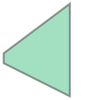

In [6]:
para_defo.iloc[0]['geometry']

In [7]:
para_shape - para_defo.iloc[0]['geometry']

/tmp/ipykernel_283/915341063.py:1: FutureWarning: '-' operator will be deprecated. Use the 'difference' method instead.
  para_shape - para_defo.iloc[0]['geometry']


4    MULTIPOLYGON (((-46.38429 -1.03692, -46.38484 ...
dtype: geometry

In [ ]:
## Impossibly slow.

#%%time
#para_defo_shape = para_shape
#for x in range(0,len(para_defo)):
#    para_defo_shape = para_defo_shape - para_defo.iloc[x]['geometry']

In [51]:
#para_defo_shape

In [49]:
## Impossibly slow.

#%%time
#para_defo_shape2 = state_shapes[state_shapes['sigla'] == 'PA'].overlay(para_defo, how='difference')

In [50]:
#para_defo_shape2

### Testing Polygon Bounding Box Calculation and FIltering (cuSpatial)

In [240]:
#%%time
# Save shapefile with only Para deforestation polygons.
#deforestation[deforestation['state'] == 'PA'].to_file('tempfile.shp')
#para_defo.to_file('tempfile.shp')

In [241]:
# Confirm that file is readable by GeoPandas. This should mean it is also readable by cuspatial.
#gpd.read_file('tempfile.shp')

In [13]:
# Something about the way GeoPandas is saving the Para deforestation DataFrame is breaking cuspatial loading.
# Going to proceed with the entire deforestation shapefile.

#%%time
## Open shapefile with cuspatial.
#para_defo = cuspatial.read_polygon_shapefile('tempfile.shp')

In [32]:
## Check contents.
#para_defo

In [315]:
%%time
# Load shapefile.
deforestation = cuspatial.read_polygon_shapefile('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

CPU times: user 4.43 s, sys: 2.15 s, total: 6.58 s
Wall time: 19.1 s


In [316]:
%%time
# Perform bounding box calculation.
defo_bbox = cuspatial.polygon_bounding_boxes(deforestation[0], 
                                         deforestation[1], 
                                         deforestation[2]['x'], 
                                         deforestation[2]['y']
                                        )

CPU times: user 88.5 ms, sys: 0 ns, total: 88.5 ms
Wall time: 89.7 ms


In [317]:
# Checking how many suspicious zeros are showing up in our bounding boxes.
defo_bbox['x_min'].value_counts()

 0.000000     435
-50.750000     79
-50.500000     52
-50.000000     50
-52.000000     47
             ... 
-64.466854      1
-60.528475      1
-47.151825      1
-61.969309      1
-55.240386      1
Name: x_min, Length: 580053, dtype: int32

In [320]:
defo_bbox['x_max'].value_counts()

 0.000000     435
-50.750000     50
-50.500000     43
-50.250000     42
-52.000000     35
             ... 
-60.528475      1
-48.204854      1
-46.607100      1
-50.791933      1
-51.688241      1
Name: x_max, Length: 579534, dtype: int32

In [318]:
defo_bbox['y_min'].value_counts()

 0.000000    435
-3.500000     71
-3.750000     47
-4.250000     46
-9.250000     31
            ... 
-1.758200      1
-2.160310      1
-7.011757      1
-4.242639      1
-4.675998      1
Name: y_min, Length: 573735, dtype: int32

In [319]:
defo_bbox['y_max'].value_counts()

 0.000000     437
-3.500000      58
-4.000000      46
-3.250000      42
-4.250000      41
             ... 
-9.679672       1
-10.783912      1
 3.157614       1
-3.392980       1
-13.186774      1
Name: y_max, Length: 575800, dtype: int32

In [321]:
defo_gpd = gpd.read_file('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

In [322]:
len(defo_gpd)

599819

In [323]:
len(defo_bbox)

599819

In [324]:
# Add bounding boxes to DataFrame.
defo_gpd['x_min'] = defo_bbox['x_min'].to_pandas()
defo_gpd['x_max'] = defo_bbox['x_max'].to_pandas()
defo_gpd['y_min'] = defo_bbox['y_min'].to_pandas()
defo_gpd['y_max'] = defo_bbox['y_max'].to_pandas()

In [325]:
# Parameters for test.
centroid_lat = -1.672125
centroid_lon = -53.617889
span = 15

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and 100 pixels in all directions.
min_lat = centroid_lat - (lat_step * span)
max_lat = centroid_lat + (lat_step * span)
min_lon = centroid_lon - (lon_step * span)
max_lon = centroid_lon + (lon_step * span)

In [326]:
min_lon, max_lon, min_lat, max_lat

(-53.668440616872985,
 -53.56733738312701,
 -1.7229953490163887,
 -1.6212546509836114)

In [327]:
centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
         (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
        (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0)]

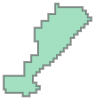

In [328]:
defo_gpd.iloc[238].geometry

In [329]:
centroid = gpd.points_from_xy([centroid_lon], [centroid_lat])
centroid_defo['geometry'].contains(centroid[0]).value_counts()

False    5
dtype: int64

In [330]:
lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
grid = list(itertools.product(lons, lats))

In [331]:
grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])

In [332]:
%%time
res = []
for p in grid_points:
    res.append(centroid_defo['geometry'].contains(p))

CPU times: user 40.3 ms, sys: 0 ns, total: 40.3 ms
Wall time: 39.3 ms


In [333]:
pd.concat(res).value_counts()

False    5120
dtype: int64

In [334]:
pd.concat(res)[pd.concat(res) == True]

Series([], dtype: bool)

In [335]:
defo_gpd.iloc[2912]

uid                                                      604903
state                                                        PA
path_row                                                  22762
main_class                                         DESMATAMENTO
class_name                                                d2010
def_cloud                                                2009.0
julian_day                                                180.0
image_date                                           2010-06-29
year                                                     2010.0
area_km                                                 0.14511
scene_id                                                 1128.0
source                                                     None
satellite                                                  None
sensor                                                     None
uuid                       0eb44bfc-2699-47e0-bd0e-5a816eb87368
geometry      POLYGON ((-54.587420904999

In [336]:
grid_gdf = gpd.GeoDataFrame(grid_points)

In [337]:
grid_gdf['contained'] = grid_gdf[0].within(defo_gpd.iloc[2912].geometry)

In [338]:
grid_gdf[grid_gdf['contained'] == True]

,0,contained


In [339]:
min_lon, max_lon, min_lat, max_lat

(-53.668440616872985,
 -53.56733738312701,
 -1.7229953490163887,
 -1.6212546509836114)

In [340]:
grid_gdf

,0,contained
0,POINT (-53.66844 -1.72300),False
1,POINT (-53.66844 -1.71960),False
2,POINT (-53.66844 -1.71621),False
3,POINT (-53.66844 -1.71282),False
4,POINT (-53.66844 -1.70943),False
...,...,...
1019,POINT (-53.56397 -1.63143),False
1020,POINT (-53.56397 -1.62804),False
1021,POINT (-53.56397 -1.62465),False
1022,POINT (-53.56397 -1.62125),False


In [341]:
centroid_defo

,uid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry,x_min,x_max,y_min,y_max
32229,457017,PA,22761,DESMATAMENTO,d2016,0.0,229.0,2016-08-16,2016.0,0.089403,100317.0,None,None,None,7048840c-d52b-4e36-8477-e468d260035f,"POLYGON ((-53.79397 -1.47840, -53.79236 -1.478...",-53.645485,-53.641851,-1.649479,-1.642757
32230,458287,PA,22761,DESMATAMENTO,d2017,0.0,199.0,2017-07-18,2017.0,0.145106,100558.0,None,None,None,cd21c477-f901-4e83-9649-d769829f9aab,"POLYGON ((-53.68772 -1.46064, -53.68772 -1.458...",-53.651941,-53.648109,-1.623660,-1.621772
221917,1268684,AM,23063,DESMATAMENTO,d2008,2007.0,228.0,2008-08-15,2008.0,0.065722,668.0,None,None,None,58c8320c-e86b-489f-955b-f47c0e362c14,"POLYGON ((-59.16297 -3.69953, -59.16272 -3.699...",-53.621175,-53.617140,-1.630111,-1.626611
450933,1503759,PA,22964,DESMATAMENTO,d2018,0.0,200.0,2018-07-19 12:00:00,2018.0,0.075405,101041.0,None,None,None,573d4acc-c07f-4f8d-9e4f-8b252c67205d,"POLYGON ((-57.48846 -5.13623, -57.48833 -5.136...",-53.624243,-53.620468,-1.643292,-1.640230
531208,1071191,PA,22362,DESMATAMENTO,d2019,0.0,221.0,2019-08-09,2019.0,0.492656,132.0,None,None,None,6d67f1f6-2a23-4410-9a8d-aa97a662e035,"POLYGON ((-48.08929 -2.84230, -48.08893 -2.842...",-53.601100,-53.594106,-1.638719,-1.635488


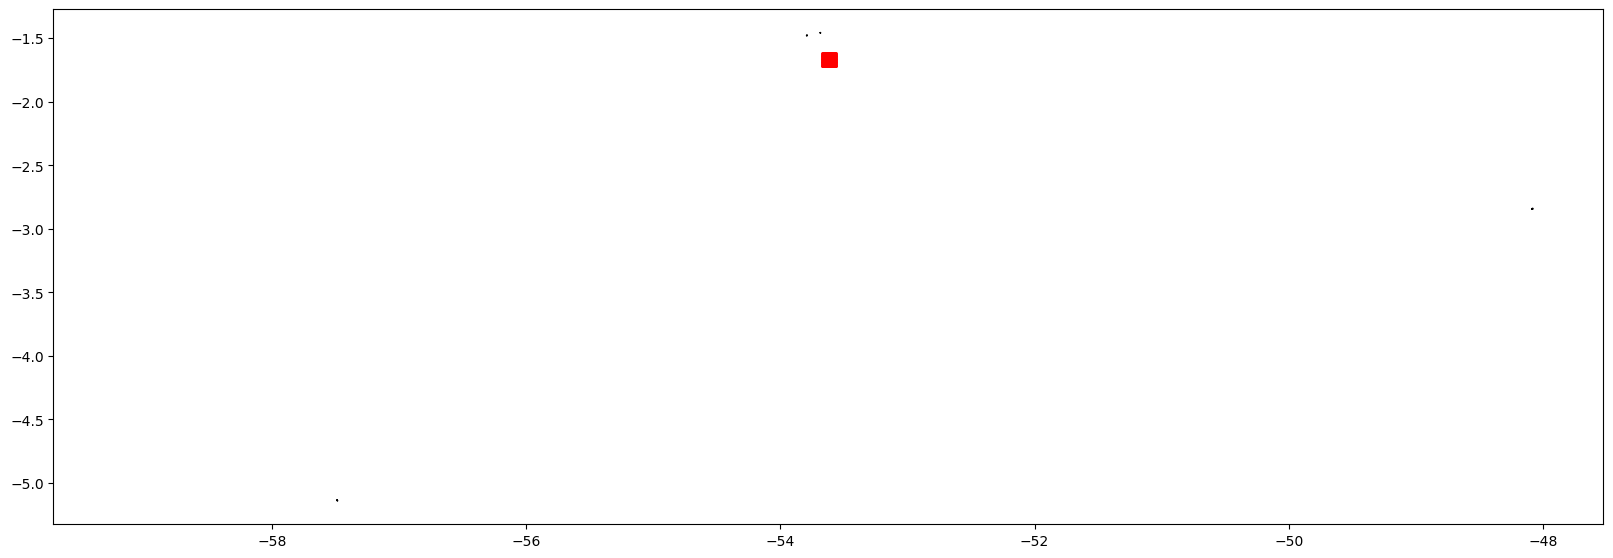

In [342]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

#ax.set_aspect('equal')

centroid_defo.plot(ax=ax, edgecolor='black')
grid_gdf.set_geometry(0).plot(ax=ax, color='red', markersize=0.5)

plt.show()

In [343]:
centroid_defo.bounds

,minx,miny,maxx,maxy
32229,-53.793973,-1.481852,-53.789244,-1.477857
32230,-53.687718,-1.460910,-53.683211,-1.456715
221917,-59.162968,-3.701412,-59.160009,-3.698721
450933,-57.488463,-5.140458,-57.482426,-5.133289
531208,-48.089291,-2.845400,-48.079635,-2.840395


In [344]:
centroid_defo[['x_min','y_min','x_max','y_max']]

,x_min,y_min,x_max,y_max
32229,-53.645485,-1.649479,-53.641851,-1.642757
32230,-53.651941,-1.623660,-53.648109,-1.621772
221917,-53.621175,-1.630111,-53.617140,-1.626611
450933,-53.624243,-1.643292,-53.620468,-1.640230
531208,-53.601100,-1.638719,-53.594106,-1.635488


In [345]:
centroid_defo

,uid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry,x_min,x_max,y_min,y_max
32229,457017,PA,22761,DESMATAMENTO,d2016,0.0,229.0,2016-08-16,2016.0,0.089403,100317.0,None,None,None,7048840c-d52b-4e36-8477-e468d260035f,"POLYGON ((-53.79397 -1.47840, -53.79236 -1.478...",-53.645485,-53.641851,-1.649479,-1.642757
32230,458287,PA,22761,DESMATAMENTO,d2017,0.0,199.0,2017-07-18,2017.0,0.145106,100558.0,None,None,None,cd21c477-f901-4e83-9649-d769829f9aab,"POLYGON ((-53.68772 -1.46064, -53.68772 -1.458...",-53.651941,-53.648109,-1.623660,-1.621772
221917,1268684,AM,23063,DESMATAMENTO,d2008,2007.0,228.0,2008-08-15,2008.0,0.065722,668.0,None,None,None,58c8320c-e86b-489f-955b-f47c0e362c14,"POLYGON ((-59.16297 -3.69953, -59.16272 -3.699...",-53.621175,-53.617140,-1.630111,-1.626611
450933,1503759,PA,22964,DESMATAMENTO,d2018,0.0,200.0,2018-07-19 12:00:00,2018.0,0.075405,101041.0,None,None,None,573d4acc-c07f-4f8d-9e4f-8b252c67205d,"POLYGON ((-57.48846 -5.13623, -57.48833 -5.136...",-53.624243,-53.620468,-1.643292,-1.640230
531208,1071191,PA,22362,DESMATAMENTO,d2019,0.0,221.0,2019-08-09,2019.0,0.492656,132.0,None,None,None,6d67f1f6-2a23-4410-9a8d-aa97a662e035,"POLYGON ((-48.08929 -2.84230, -48.08893 -2.842...",-53.601100,-53.594106,-1.638719,-1.635488


### Testing Polygon Bounding Box Calculation and FIltering (GeoPandas)

In [289]:
%%time
# Try GeoPandas load.
defo_gpd = gpd.read_file('Yearly_Deforestation_Biome/yearly_deforestation_biome.shp')

CPU times: user 32.1 s, sys: 3.21 s, total: 35.4 s
Wall time: 48.7 s


In [290]:
%%time
# Get bouinding boxes.
gpd_bbox = defo_gpd.bounds
gpd_bbox

CPU times: user 13.1 s, sys: 0 ns, total: 13.1 s
Wall time: 13.1 s


,minx,miny,maxx,maxy
0,-63.051908,2.596715,-63.048150,2.599951
1,-62.638652,2.697585,-62.636223,2.699288
2,-63.343713,2.781734,-63.339324,2.784656
3,-63.340411,2.783470,-63.339335,2.783835
4,-63.164857,2.634077,-63.162167,2.637574
...,...,...,...,...
599814,-57.407988,-14.430745,-57.397497,-14.421868
599815,-57.477082,-14.389886,-57.474099,-14.386342
599816,-57.404186,-14.396582,-57.403953,-14.396567
599817,-57.399649,-14.421868,-57.399111,-14.421330


In [292]:
# Add bounding boxes to DataFrame.
defo_gpd['x_min'] = gpd_bbox['minx']
defo_gpd['x_max'] = gpd_bbox['maxx']
defo_gpd['y_min'] = gpd_bbox['miny']
defo_gpd['y_max'] = gpd_bbox['maxy']

In [293]:
# Parameters for test.
centroid_lat = -1.672125
centroid_lon = -53.617889
span = 15

# Calculate location if we move 375 meters North and use to get grid steps.
lat_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=0).latitude
lat_step = abs(centroid_lat - lat_375)

# Calculate location if we move 375 meters East and use to get grid steps.
lon_375 = gpx.distance(kilometers=0.375).destination((centroid_lat, centroid_lon), bearing=90).longitude
lon_step = abs(centroid_lon - lon_375)

# Get bounding box of centroid and 100 pixels in all directions.
min_lat = centroid_lat - (lat_step * span)
max_lat = centroid_lat + (lat_step * span)
min_lon = centroid_lon - (lon_step * span)
max_lon = centroid_lon + (lon_step * span)

In [294]:
centroid_defo = defo_gpd[(defo_gpd['x_min'] >= min_lon) & (defo_gpd['x_max'] <= max_lon) &
         (defo_gpd['y_min'] >= min_lat) & (defo_gpd['y_max'] <= max_lat) &
        (defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] + defo_gpd['x_min'] != 0)]

In [295]:
centroid_defo

,uid,state,path_row,main_class,class_name,def_cloud,julian_day,image_date,year,area_km,scene_id,source,satellite,sensor,uuid,geometry,x_min,x_max,y_min,y_max
32235,451935,PA,22761,DESMATAMENTO,d2015,0.0,226.0,2015-08-14,2015.0,0.161589,2575.0,None,None,None,5435c1b1-2334-483b-b95e-a9fb5119549b,"POLYGON ((-53.64548 -1.64330, -53.64548 -1.643...",-53.645485,-53.641851,-1.649479,-1.642757
32236,972631,PA,22761,DESMATAMENTO,d2019,0.0,256.0,2019-09-13,2019.0,0.065526,122.0,None,None,None,68aa3716-03f2-438a-bf44-b2e2f0cfca77,"POLYGON ((-53.65194 -1.62261, -53.65168 -1.622...",-53.651941,-53.648109,-1.623660,-1.621772
222024,416086,PA,22761,DESMATAMENTO,d2008,0.0,271.0,2008-09-27,2008.0,0.079449,627.0,None,None,None,343697c2-63f7-402d-bcf7-39c6373d1c08,"POLYGON ((-53.62117 -1.62661, -53.61875 -1.626...",-53.621175,-53.617140,-1.630111,-1.626611
451199,451929,PA,22761,DESMATAMENTO,d2015,0.0,226.0,2015-08-14,2015.0,0.075871,2575.0,None,None,None,78a8253e-846b-4bc8-a9f1-20fdd6ab2e8b,"POLYGON ((-53.62424 -1.64168, -53.62423 -1.641...",-53.624243,-53.620468,-1.643292,-1.640230
531519,416094,PA,22761,DESMATAMENTO,d2008,0.0,271.0,2008-09-27,2008.0,0.115781,627.0,None,None,None,c761443c-bdd5-4b52-9935-8e229602fc63,"POLYGON ((-53.60110 -1.63737, -53.60110 -1.637...",-53.601100,-53.594106,-1.638719,-1.635488


In [308]:
lats = [min_lat + lat_step * x for x in range(0,span * 2 + 2)]
lons = [min_lon + lon_step * x for x in range(0,span * 2 + 2)]
grid = list(itertools.product(lons, lats))

In [309]:
grid_points = gpd.points_from_xy([x[0] for x in grid], [y[1] for y in grid])

In [310]:
%%time
res = []
for p in grid_points:
    res.append(centroid_defo['geometry'].contains(p))

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 39.8 ms


In [311]:
pd.concat(res).value_counts()

False    5117
True        3
dtype: int64

In [312]:
pd.concat(res)[pd.concat(res) == True]

32235     True
451199    True
531519    True
dtype: bool

In [313]:
grid_gdf = gpd.GeoDataFrame(grid_points)

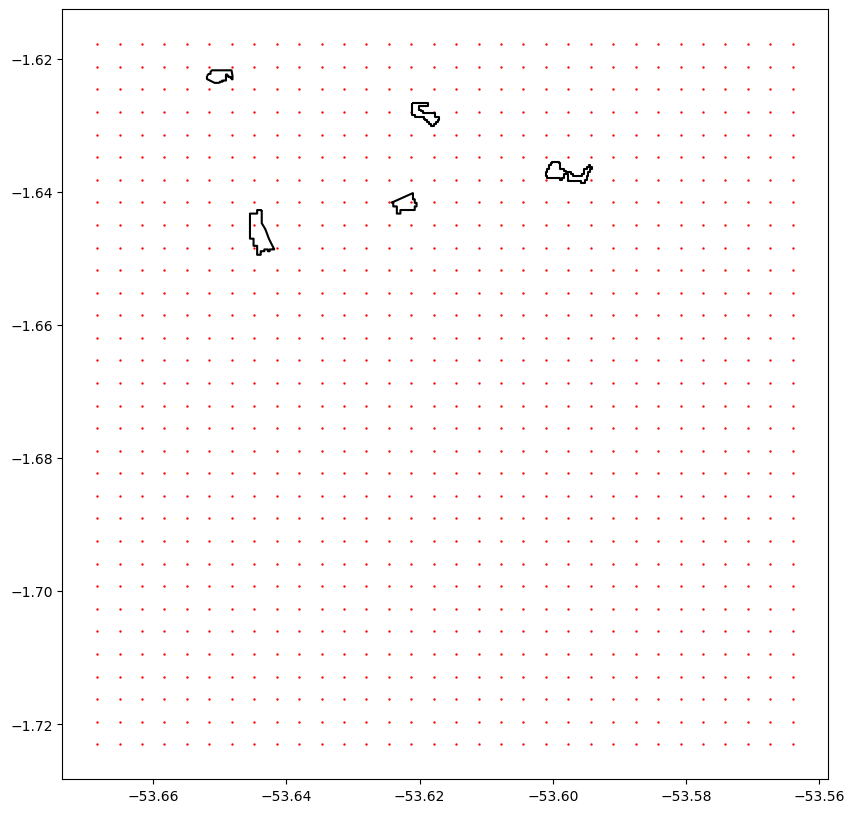

In [314]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))

#ax.set_aspect('equal')

centroid_defo.boundary.plot(ax=ax, edgecolor='black')
grid_gdf.set_geometry(0).plot(ax=ax, color='red', markersize=0.5)

plt.show()

### Geographic Filtering

In [ ]:
# Get polygon count.
poly_count = len(deforestation[0])

# Make iterations.
pip_iterations = create_iterations(0, poly_count + 1, 31)

In [ ]:
pip_iterations

In [ ]:
%%time
# Check pixels from dataframe to see if they're in Para.
# Source Article: https://medium.com/swlh/how-to-perform-fast-and-powerful-geospatial-data-analysis-with-gpu-48f16a168b10
# Source Code: https://github.com/shakasom/geospatial-gpu
#pip = cuspatial.point_in_polygon(px_combined['Lon'] , px_combined['Lat'], 
#                                         deforestation[0], 
#                                         deforestation[1], 
#                                         deforestation[2]['x'], 
#                                         deforestation[2]['y']
#                                       )

pip_df = perform_pip(px_combined,
                     deforestation,
                     pip_iterations
                    )

In [ ]:
pip_df

In [ ]:
32 * 32

In [ ]:
px_combined['Deforested'] = pip

In [ ]:
%%time
any_pip_df = any_pip(px_combined,
                     deforestation,
                     pip_iterations
                    )

In [ ]:
dummy_points = [x - y for x in range(0,32) for y in range(32,0,-1)]
dummy_points2 = [x + y for x in range(32,0,-1) for y in range(0,32)]
dummy_df = cudf.DataFrame(list(zip(dummy_points,dummy_points2)), columns = ['Lat', 'Lon'])
dummy_df

In [ ]:
%%time
any_pip_df2 = any_pip(dummy_df,
                     deforestation,
                     pip_iterations
                    )

In [ ]:
simp_df = cudf.DataFrame([[-5,12]], columns = ['Lat', 'Lon'])
simp_df

In [ ]:
%%time
any_pip_df3 = any_pip(simp_df,
                     deforestation,
                     pip_iterations
                    )

### Quality Check and Save

In [ ]:
# Perform filtering.
px_deforested = px_combined[px_combined['Deforested'] == True]

In [ ]:
# Check residual dataset percentage.
len(px_deforested) / len(px_deforested)

In [ ]:
len(px_combined)

In [ ]:
len(px_deforested)

In [ ]:
# Save filtered GeoDataFrame.
px_deforested.to_csv('VIIRS_Deforested.csv')

### FIltering to September

In [ ]:
# Dropping unused columns.
px_deforested = px_deforested.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1)

In [ ]:
px_deforested['YYYYMMDD'].astype(str)

In [ ]:
# Add date.
px_deforested['Date'] = pd.to_datetime(px_deforested['YYYYMMDD'].astype(str).to_pandas())

In [ ]:
# Add month and year.
px_deforested['Month'] = pd.DatetimeIndex(px_deforested['Date'].to_pandas()).month
px_deforested['Year'] = pd.DatetimeIndex(px_deforested['Date'].to_pandas()).year

In [ ]:
# Filter to September and see how much data we're working with.
px_deforested[px_deforested['Month'] == 9].Year.value_counts()

In [ ]:
# Save Septmber data.
px_deforested[px_deforested['Month'] == 9].to_csv('VIIRS_Deforested_September.csv')